# Model

In [77]:
import matplotlib.pyplot as plt
import numpy as np
# import pandas as pd
# import seaborn as sns
from scipy.integrate import odeint
from scipy.optimize import fsolve
import scipy as sp
#from numba import jit  
#import wallEquations
# Functions

def QLossFunc(heatCoef,Area,Tbuilding,Toutside):
    """Returns the heat loss of spesific item

    Args:
        heatCoef (float): heat transfer coefficient
        Area (float): area of specific item
        Tbuilding (float): temperatur of building 
        Toutside (float): temperature outside

    Returns:
        float: Heat loss from specific item
    """
    return heatCoef*Area*(Tbuilding-Toutside)

def rhoRelative(T, rho0=1.1839, T0=298.15):
    """Returns the density of given T

    Args:
        rho0 (float): density of air at 1atm
        T0 (float): 25 degree celc
        T (float): input temperature

    Returns:
        float: density of input temperature
    """
    return (rho0*T0) / T

def specEnthalpy(T):
    return 30.184e3+10*(2501 + 1.84 * T)
def checkIfNegative(val):
    if val < 0:
        return 0
    return val

class model:
    # Global/Static variable
    qlossWalls = 0
    QlossRoof = 0
    QlossFloor = 0
    Qlossfur = 0
    def __init__(self, Toutside, peopleCount=1, airflow=0.7, dt=1, simTime=100, initBoundryTemp=20+273.15, OutsideDataArray=None, peopleDataArray=None, QheaterDataArray=None, QflowDataArray=None ):
       
        # Time constants
        self.dt = dt
        self.deltaH = 1/self.dt 
        self.simulationTime = 0
        self.simTimeEnd = simTime

        # Building dimentions
        self.l = 3.65 # building length [m]
        self.w = 4 # building width [m]
        self.h = 3.3 # building height [m]

        self.Vb = 47267 # self.l*self.h*self.w

        # Other variables
        self.cPB = 1.005e3 # J/kg Specific heat capacity of moist air inside building
        self.R = 8.314472  # Pa m^3/ mol K Gas constant
        self.M_air = 28.97e-3 # [kg/mol] Molar mass of dry air
        self.M_H2O = 18e-3 # [kg/mol] Molar mass of water
        self.eta = 0.7
        self.Cp_dryair=1006
        self.Cp_H2O=1840
        self.h_fg = 2260000
        self.Toutside = Toutside

        # Areas 
        self.Awindow = 1996 # NOTE: Combined with Adoor! 1.2 # [m^2] Area of window
        self.Adoor = 1996 # 0.75*2.1 # [m^2] Area of door
        self.Awalls = 3486 #2*(self.l+self.w)*self.h - (self.Awindow+self.Adoor) # [m^2] Area of walls
        self.AwallsBase = 1878 # [m^2] Area of walls
        self.Aroof = 3090 # self.l*self.w # [m^2] Area of roof
        self.Afloor = 2269 #  self.l*self.w # [m^2] Area of floor
        
        # Ventilation
        self.vIn = 2500 / (self.Afloor) # (airflow )/(3600*(self.Afloor)) #(self.l*self.w)
        self.vOut = self.vIn

        # Overall heat transfer coefficients
        self.Uwindow = 0 # NOTE: Combined with Adoor!  1.2 # [W/m^2K] Heat transfer coeff of window
        self.Udoor = 0.8 #1.2 # [W/m^2K] Heat transfer coeff of door
        self.Uwalls = 0.17# 0.18 # [W/m^2K] Heat transfer coeff of walls
        self.UwallsBase = 0.15# [W/m^2K] Heat transfer coeff of walls
        self.Uroof = 0.13 # [W/m^2K] Heat transfer coeff of roof
        self.Ufloor = 0.18 #  0.15 # [W/m^2K] Heat transfer coeff of floor

        init_Temp = initBoundryTemp
        self.TwallInit = [init_Temp,init_Temp,init_Temp,init_Temp]
        self.TroofInit = [init_Temp,init_Temp,init_Temp,init_Temp]
        self.TfloorInit = [init_Temp,init_Temp,init_Temp]
        self.TfurInit = [init_Temp]

        self.lastTime = 0
        self.Qwalls = 0
        self.TempwallsLst = []
        self.Qroof = 0
        self.TemproofLst = []
        self.Qfloor = 0
        self.TempfloorLst = []
        self.Qfur = 0
        self.TempfurLst = []

        # Q gain factors
        self.Qheater = 0
        self.Qpeople = 0
        self.Qappliances = 150
        self.Qsolar = 0

        # Test values
        self.ToutLst = list()
        #self.ToutLst.append([0,self.Toutside])
        self.QpeopleList = list()
        self.PowerList = list()
        self.FlowList = list()
        self.timer = 6

        self.heaterOnOffLst = []

        # More people values
        self.peopleCount = peopleCount

        # NORCE data 
        self.OutsideDataArray = OutsideDataArray
        self.peopleDataArray = peopleDataArray
        self.QheaterDataArray = QheaterDataArray
        self.QflowDataArray = QflowDataArray

    def Qdot(self, Tb, time):
        """Returns heat loss and gain of all elements on specific room temperature

        Args:
            Tb (float): Room temperature at given time
        """
        # Heat loss
        self.Qwindow = QLossFunc(self.Uwindow, self.Awindow, Tb, self.Toutside) # W, 
        self.Qdoor = QLossFunc(self.Udoor, self.Adoor, Tb, self.Toutside) # W
        self.Qwalls = QLossFunc(self.Uwalls, self.Awalls, Tb, self.Toutside) # W
        self.QwallBase = QLossFunc(self.UwallsBase, self.AwallsBase, Tb, self.Toutside) # W
        self.Qfloor = QLossFunc(self.Ufloor, self.Afloor, Tb, self.Toutside) # W
        self.Qroof = QLossFunc(self.Uroof, self.Aroof, Tb, self.Toutside) # W
        #hb = 2
        # if self.lastTime < time: 
        #     t = np.arange(self.lastTime, self.lastTime+time)
        #     if time != 0:
        #         y0 = self.TwallInit
        #         y0 = odeint(self.Qloss_walls, y0, t,(self.Awalls, self.Tb, 2 ),rtol=1e-3,atol=1e-3)  
        #         self.Qwalls = checkIfNegative(model.qlossWalls)
        #         self.TwallInit = y0[-1]
                
        #         y02 = self.TroofInit
        #         y02 = odeint(self.Qloss_roof, y02, t,(self.Aroof, self.Tb, 2 ),rtol=1e-3,atol=1e-3)  
        #         self.Qroof = checkIfNegative(model.QlossRoof)
        #         self.TroofInit = y02[-1]

        #         y03 = self.TfloorInit
        #         y03 = odeint(self.Qloss_floor, y03, t,(self.Afloor, self.Tb, 2 ),rtol=1e-3,atol=1e-3)  
        #         self.Qfloor = checkIfNegative(model.QlossFloor)
        #         self.TfloorInit = y03[-1]

        #         y04 = self.TfurInit
        #         y04 = odeint(self.Qloss_furniture, y04, t,(0, self.Tb, 2 ),rtol=1e-3,atol=1e-3)  
        #         self.Qfur = checkIfNegative(model.Qlossfur)
        #         self.TfurInit = y04[-1]
                
        # Record temperature inside boudries
        # self.TempwallsLst.append([time,self.TwallInit[0]])
        # self.TemproofLst.append([time,self.TroofInit[0]])
        # self.TempfloorLst.append([time,self.TfloorInit[0]])
        # self.TempfurLst.append([time,self.TfurInit[0]])

        self.Qloss = self.Qwindow + self.Qdoor + self.Qwalls + self.QwallBase + self.Qroof + self.Qfloor
        self.lastTime = time

        self.Qgain = self.Qheater + self.Qpeople + self.Qappliances + self.Qsolar
        self.Q = self.Qgain - self.Qloss
    
    def buildingModel(self, Tb, t, varyingOutdoorTemp=False, varyingPeople=False, varyingQheater=False, varyingFlow=False):
        self.Tb = Tb

        if varyingFlow:
          flowIndex = self.QflowDataArray['time'].sub(t).abs().idxmin()
          self.vIn = self.QflowDataArray["value"].loc[flowIndex]/ (self.Afloor)
          self.vOut = self.vIn    
          if self.vIn == 0:
            self.vOut = self.vIn = 0.7 / self.Afloor

        self.varyingQheater = varyingQheater
        rhoIn = self.rhoInFunc(self.Toutside)
        self.rhoIn = rhoIn
        rhoB = rhoRelative(self.Tb)
        self.rhoB = rhoB
        self.hIn, self.hOut  = self.h_Air()

        kelvin = 273.15
        if t <= 6*self.dt:
            # self.vInvOutUpdate(0.7) 
            self.heaterControl(18.7+kelvin, t)
            
        elif t > 6*self.dt and t <= 18*self.dt:
            # self.vInvOutUpdate(1.2)
            self.heaterControl(21.8+kelvin, t)
            
        elif t > 18*self.dt:
            # self.vInvOutUpdate(0.7)
            self.heaterControl(18.7+kelvin, t)
            
        self.heaterOnOffLst.append([t,self.Qheater])

        # Solar
        # if t >= 10*self.dt and t <= 14*self.dt:
        #     self.Qsolar = 100 * self.Awindow
        #     # self.vIn = 2500*5  / (self.Afloor) # (airflow )/(3600*(self.Afloor)) #(self.l*self.w)
        #     # self.vOut = self.vIn
        # else:
        #     self.Qsolar = 0
        #     # self.vIn = 2500  / (self.Afloor) # (airflow )/(3600*(self.Afloor)) #(self.l*self.w)
        #     # self.vOut = self.vIn

        # Varying Outside temperature
        if varyingOutdoorTemp:
          outdoorIndex = self.OutsideDataArray['time'].sub(t).abs().idxmin()
          self.Toutside = self.OutsideDataArray["value"].loc[outdoorIndex]
          self.ToutLst.append([t,self.Toutside])
        if varyingPeople:
          peopleIndex = self.peopleDataArray['time'].sub(t).abs().idxmin()
          self.Qpeople = self.peopleDataArray["value"].loc[peopleIndex]*80
          self.QpeopleList.append([t,self.Qpeople])

        self.PowerList.append([t,self.Qheater])
        self.FlowList.append([t,self.vIn])

          # if t > self.timer*self.dt and t <= 8*self.dt:
          #     self.Toutside += 0.01
          #     self.ToutLst.append([t,self.Toutside])
          #     self.timer += 0.01
          # elif t > self.timer*self.dt and t <= 16*self.dt:
          #     self.Toutside += 0.015
          #     self.ToutLst.append([t,self.Toutside])
          #     self.timer += 0.01
          # elif t > self.timer*self.dt and t <= 24*self.dt:
          #     self.Toutside -= 0.012
          #     self.ToutLst.append([t,self.Toutside])
          #     self.timer += 0.01


        # Update Q factor
        self.Qdot(self.Tb, t)

        dydt=self.dTbdt()
        return dydt


    def dTbdt(self):
        """Returns tempature of the room 
        
        """   
        #ventilation = (self.vIn*self.rhoIn*self.hIn - self.vOut*self.rhoB*self.hOut)
        deltaRhoB = (self.vIn*self.rhoIn-self.vOut*self.rhoB) / self.Vb

        firstPart = (self.vIn*self.rhoIn*self.hIn - self.vOut*self.rhoB*self.hOut + self.Q) / (self.Vb*self.rhoB*(self.Cp_air-(self.R/self.Mb))) - (self.Tb/self.rhoB)*deltaRhoB
        
        #secondPart = (self.Tb/self.rhoB)*deltaRhoB
        return firstPart

    def rhoInFunc(self, Toutside, RH_out=0.77, P=101325):
        #Coefficients to determine the saturation vapor pressure of water
        p1=5.2623e-09
        p2=-6.3323e-06
        p3=0.003072
        p4=-0.75032
        p5=92.195
        p6=-4556.2
        p7=91.59
    
        Psat = p1*pow(Toutside,6) + p2*pow(Toutside,5) + p3*pow(Toutside,4) + p4*pow(Toutside,3) + p5*pow(Toutside,2) + p6*Toutside + p7

        PH2O = RH_out*Psat              # [Pa] Vapor presure of water at considering temperature and pressure
        f_H2O_in = PH2O/P          # [moles of water vapor/moles of moist air] Molar fraction of water vapor in
        self.f_H2O_in = f_H2O_in

        M_in = self.M_air*(1-f_H2O_in) + self.M_H2O*f_H2O_in      # [kg/mol] Molar mass of incoming moist air
        Rho_in = P*M_in/(self.R*Toutside)   # [kg/m3] Density of inlet air
        return Rho_in

    def h_Air(self):
        """ Return specific enthalpy of incoming air
        """
        self.xi=self.f_H2O_in*self.M_H2O/(1-self.f_H2O_in)/self.M_air
        h_dryair=self.Cp_dryair*self.Toutside
        h_H2O=self.Cp_H2O*self.Toutside+self.h_fg
        h_air_in=h_dryair+self.xi*h_H2O

        xo=self.vIn*self.rhoIn*self.xi/(self.vOut*self.rhoB)

        h_air_out=self.Cp_dryair*self.Tb+xo*(self.Cp_H2O*self.Tb+self.h_fg)      
        self.Cp_air=self.Cp_dryair+self.Cp_H2O*xo

        f_H2O_out = (xo/self.M_H2O)/(xo/self.M_H2O+(1-xo)/self.M_air)
        M_out = self.M_air*(1-f_H2O_out) + self.M_H2O*f_H2O_out
        self.Mb = M_out

        return h_air_in, h_air_out
   
    def Qloss_walls(self, X, t, A,Tb, hb, Toutside=-2.2+273.15, change = 1, fsolveTol = 0.01):
        T1, T2, T3, T4 = X  # temperatures of wall layers

        hInf = 1#self.hIn #30.184e3+10*(2501 + 1.84 * Toutside)
        # Constants
        a1 = 1.7e-7*change
        a2 = 1.4e-6*change
        a3 = 2.25e-2*change
        a4 = 1.7e-7*change

        l1 = 6e-3
        l2 = 75e-3
        l3 = 8.5e-3
        l4 = 8.5e-3

        K1 = 0.14
        K2 = 0.038
        K3 = 0.026
        K4 = 0.14

        def surfaceTemp(ki,ki2,li,li2,Ti,Ti2):
            return ((ki/li)*Ti + (ki2/li2)*Ti2) / ((ki/li) + (ki2/li2))

        # Inner surface temperatures are currently computed as arithmetic
        # averages of the layer temperatures:
        T2_s = surfaceTemp(K1,K2,l1,l2,T1,T2) #0.5*(T1+T2)
        T3_s = surfaceTemp(K2,K3,l2,l3,T2,T3) #0.5*(T2+T3)
        T4_s = surfaceTemp(K3,K4,l3,l4,T3,T4) #0.5*(T3+T4)

        # Find temperatures of internal and external boundaries:
        def internalEquation(T_surface):
            return hb*(Tb-T_surface) - 0.5*K1*(T_surface-T2_s) / l1
        
        def externalEquation(T_surface):
            sigma = sp.constants.Stefan_Boltzmann
            eps = 0.8
            return hInf*A*(T_surface-Toutside) + sigma*eps*(T_surface**4 - Toutside**4) \
                                            - 0.5*K4*A*(T4_s - T_surface)/l4

        T1_s = fsolve(internalEquation, T2_s, xtol=fsolveTol)
        T5_s = fsolve(externalEquation, T4_s, xtol=fsolveTol)
        
        # Differential equations for wall layers:

        rhs1 = a1*(T2_s - 2*T1 + T1_s)/l1**2
        rhs2 = a2*(T3_s - 2*T2 + T2_s)/l2**2
        rhs3 = a3*(T4_s - 2*T3 + T3_s)/l3**2
        rhs4 = a4*(T5_s - 2*T4 + T4_s)/l4**2

        # Calculate Qloss
        
        model.qlossWalls = hb*A*(Tb-T1_s[-1]) # varme tap, NB! byttet TB og T1_s!!!!
        #print("self.Qwalls inside",self.Qwalls)
        #print(self.Qwalls)
        #print("t",t)
        return [rhs1, rhs2, rhs3, rhs4]
    
    def Qloss_roof(self, X, t, A, Tb, hb, Toutside=-2.2+273.15,change = 1, fsolveTol = 0.01):
        """
        Compute right-hand side of ODE system.
        """
        
        T1, T2, T3, T4 = X  # temperatures of wall layers

        hInf = 1#self.hIn #30.184e3+10*(2501 + 1.84 * Toutside)
        # Constants
        a1 = 1.7e-7*change
        a2 = 1.4e-6*change
        a3 = 1.8e-7*change
        a4 = 4e-7*change

        l1 = 6e-3
        l2 = 100e-3
        l3 = 11e-3
        l4 = 6.5e-4

        K1 = 0.14
        K2 = 0.038
        K3 = 0.12
        K4 = 0.027

        def surfaceTemp(ki,ki2,li,li2,Ti,Ti2):
            return ((ki/li)*Ti + (ki2/li2)*Ti2) / ((ki/li) + (ki2/li2))

        # Inner surface temperatures are currently computed as arithmetic
        # averages of the layer temperatures:
        T2_s = surfaceTemp(K1,K2,l1,l2,T1,T2) #0.5*(T1+T2)
        T3_s = surfaceTemp(K2,K3,l2,l3,T2,T3) #0.5*(T2+T3)
        T4_s = surfaceTemp(K3,K4,l3,l4,T3,T4) #0.5*(T3+T4)

        # Find temperatures of internal and external boundaries:
        
        def internalEquation(T_surface):
            return hb*(Tb-T_surface) - 0.5*K1*(T_surface-T2_s) / l1
        

        def externalEquation(T_surface):
            sigma = sp.constants.Stefan_Boltzmann
            eps = 0.8
            return hInf*A*(T_surface-Toutside) + sigma*eps*(T_surface**4 - Toutside**4) \
                                            - 0.5*K4*A*(T4_s - T_surface)/l4
        
        T1_s = fsolve(internalEquation, T2_s, xtol=fsolveTol)
        T5_s = fsolve(externalEquation, T4_s, xtol=fsolveTol)
        
        # Differential equations for wall layers:

        rhs1 = a1*(T2_s - 2*T1 + T1_s)/l1**2
        rhs2 = a2*(T3_s - 2*T2 + T2_s)/l2**2
        rhs3 = a3*(T4_s - 2*T3 + T3_s)/l3**2
        rhs4 = a4*(T5_s - 2*T4 + T4_s)/l4**2

        # Calculate Qloss
        model.QlossRoof = hb*A*(Tb-T1_s[-1])
        #print(Qloss)
        #print("t",t)

        return [rhs1, rhs2, rhs3, rhs4]
    
    def Qloss_floor(self, X, t, A, Tb, hb, q=0, Toutside=-2.2+273.15, change = 1, fsolveTol = 0.01):
            """
            Compute right-hand side of ODE system.
            """
            
            T1, T2, T3 = X  # temperatures of wall layers
            # Constants
            a1 = 4e-7*change
            a2 = 1.7e-7*change
            a3 = 1.4e-6*change

            l1 = 1e-3
            l2 = 9e-3
            l3 = 75e-3

            K1 = 0.027
            K2 = 0.14
            K3 = 0.038

            def surfaceTemp(ki,ki2,li,li2,Ti,Ti2):
                return ((ki/li)*Ti + (ki2/li2)*Ti2) / ((ki/li) + (ki2/li2))

            # Inner surface temperatures are currently computed as arithmetic
            # averages of the layer temperatures:
            T2_s = surfaceTemp(K1,K2,l1,l2,T1,T2) #0.5*(T1+T2)
            T3_s = surfaceTemp(K2,K3,l2,l3,T2,T3) #0.5*(T2+T3)
            T4_s = Toutside + 5 # average ground temp 5 degrees higher than outdoors

            # Find temperatures of internal and external boundaries:
            
            def internalEquation(T_surface):
                return hb*(Tb-T_surface) - 0.5*K1*(T_surface-T2_s) / l1
            
            T1_s = fsolve(internalEquation, T2_s, xtol=fsolveTol)

            # Heater variables
            rho1 = 55
            rho2 = 615
            rho3 = 32
            cp1 = 1210
            cp2 = 1317
            cp3 = 835
            # Differential equations for wall layers:

            rhs1 = a1*(T2_s - 2*T1 + T1_s)/l1**2 + q/(rho1*cp1)
            rhs2 = a2*(T3_s - 2*T2 + T2_s)/l2**2 + q/(rho2*cp2)
            rhs3 = a3*(T4_s - 2*T3 + T3_s)/l3**2 + q/(rho3*cp3)
            

            # Calculate Qloss
            model.QlossFloor = hb*A*(Tb-T1_s[-1])
            #print(Qloss)
            #print("t",t)

            return [rhs1, rhs2, rhs3]

    def Qloss_furniture(self, X, t, A, Tb, hb, Toutside=-2.2+273.15, change = 1, fsolveTol = 0.01):
        """
        Compute right-hand side of ODE system.
        """
        
        T1 = X  # temperatures of wall layers

        v = 1
        # Inner surface temperatures are currently computed as arithmetic
        # averages of the layer temperatures:
        #T2_s = 0.5*(T1+T2)
        T2_s = T1
        # Constants
        a1 = 1.8e-7*change

        r = np.cbrt((3*v)/(4*np.pi))
        l1 = r
        K1 = 2
 
        # Find temperatures of internal boundary:
        
        def outerLayer(T_surface):  
            return hb*(Tb-T_surface) - 0.5*K1*(T_surface-T2_s) / l1

        T1_s = fsolve(outerLayer, T2_s, xtol=fsolveTol)
        # Differential equations for wall layers:
        rhs1 = a1*(T2_s - 2*T1 + T1_s)/l1**2 + a1*(1/r)*((T2_s-T1_s)/(r))

        
        A = 4*np.pi*r**2
        # Calculate Qloss
        model.Qlossfur = hb*A*(Tb-T1_s[-1])
        #print(Qloss)
        #print("t",t)

        return rhs1

    def vInvOutUpdate(self, speed):
        self.vIn = (speed * 1)/(3600)*(self.Afloor)
        self.vOut = self.vIn 
        
    def heaterControl(self, setTemp, t):
      #QheaterIndex = self.QheaterDataArray['time'].sub(t).abs().idxmin()
      #self.Qheater = self.QheaterDataArray["value"].loc[QheaterIndex]*1000
      if self.Tb < setTemp:
        if self.varyingQheater:
          QheaterIndex = self.QheaterDataArray['time'].sub(t).abs().idxmin()
          self.Qheater = self.QheaterDataArray["value"].loc[QheaterIndex]*1000
        else:
          self.Qheater = 6500*1000
      elif self.Tb > setTemp:
        # if self.varyingQheater:
        #   QheaterIndex = self.QheaterDataArray['time'].sub(t).abs().idxmin()
        #   self.Qheater = self.QheaterDataArray["value"].loc[QheaterIndex]*1000
        # else:
        self.Qheater = 0




## Simulaiton

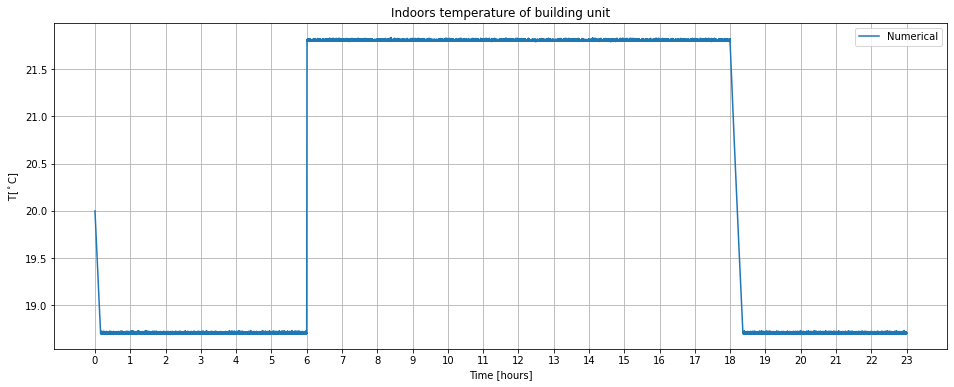

In [19]:
from scipy.integrate import odeint

K = 273.15
dt = 60*60
simTime = 23*dt
tolerance = 1e-4

tSimArray=np.arange(0,simTime,1)
y0 = 20+K
Toutside = -2.2 + K #-2.2 +K
case2Model = model(Toutside,dt = dt,simTime=simTime )
solConstantTemp = odeint(case2Model.buildingModel, y0, tSimArray,args=(False, ),  rtol=tolerance,atol=tolerance) 

fig = plt.figure(figsize=(16, 6))
plt.grid()
plt.xticks(np.arange(0,24,1))

plt.plot(tSimArray/dt, solConstantTemp-K, label="Numerical")
plt.xlabel('Time [hours]')
plt.ylabel('T[$^\circ$C]')
plt.title("Indoors temperature of building unit")
plt.legend()

# plt.show()

In [63]:
case2Model.vIn

0.44119444444444444

## NORCE data

In [25]:
import pandas as pd
import datetime

def convertTime(csvFile, day=3):
  df = pd.read_csv(csvFile)
  df.time = pd.to_datetime(df.time)
  dt = datetime.datetime(2021,3,day)
  rows = df['time'].apply(
      lambda x: x.year == dt.year and x.month==dt.month and x.day== dt.day 
      )
  dfmin = df[rows].copy()
  idx = pd.date_range(dt, freq='1h', periods=26).strftime('%H:%M') 
  dfmin.time = dfmin.time.dt.time
  return dfmin, idx


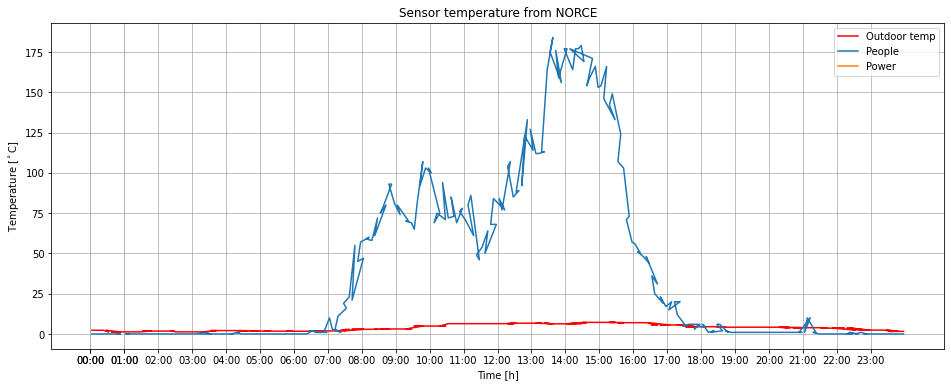

In [5]:
import matplotlib.pyplot as plt

dfOutdoorTemp, idxOutdoorTemp = convertTime('/content/drive/MyDrive/UiS/1 Master Thesis/data/correlated_weather_data.csv')
dfPeople1, idxPeople1 = convertTime('/content/drive/MyDrive/UiS/1 Master Thesis/data/people1.csv')
dfPeople2, idxPeople2 = convertTime('/content/drive/MyDrive/UiS/1 Master Thesis/data/people2.csv')
dfPower1, idxPower1 = convertTime('/content/drive/MyDrive/UiS/1 Master Thesis/data/power1.csv')
dfPower2, idxPower2 = convertTime('/content/drive/MyDrive/UiS/1 Master Thesis/data/power2.csv')
dfPeople = dfPeople1.copy()
dfPeople.value = dfPeople.value + dfPeople2.value

dfPower = dfPower1.copy()
dfPower.value = dfPower1.value + dfPower2.value

fig = plt.figure(figsize=(16, 6))


plt.title("Sensor temperature from NORCE")
plt.grid()
plt.ylabel("Temperature [$^\circ$C]")
plt.xlabel("Time [h]")
pd.plotting.register_matplotlib_converters()
plt.plot(dfOutdoorTemp.time, dfOutdoorTemp.value, label="Outdoor temp", color='red')
plt.plot(dfPeople.time, dfPeople.value, label="People")
plt.plot(dfPower.time, dfPower.value, label="Power")
plt.xticks(idxOutdoorTemp)
plt.legend()
plt.show()

In [10]:
dfFlow.to_excel("flow.xlsx")  

## Data with varying outside temp from NORCE

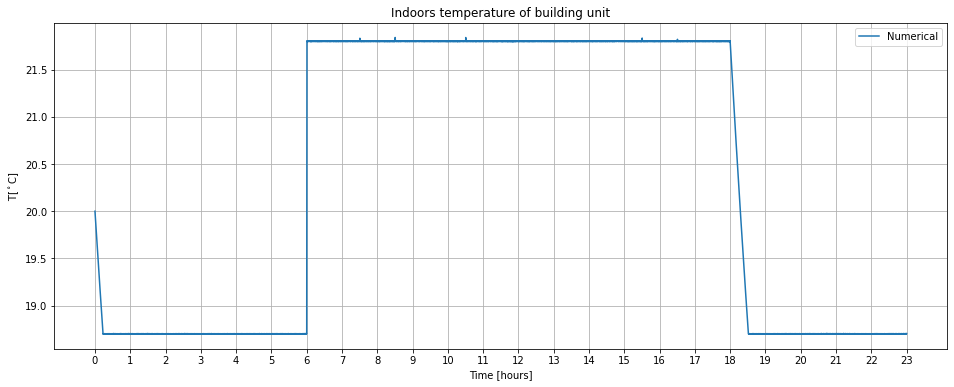

In [ ]:
from scipy.integrate import odeint
import time
from datetime import datetime, timedelta
#dfOutdoorTemp, idxOutdoorTemp = convertTime('/content/drive/MyDrive/UiS/1 Master Thesis/data/correlated_weather_data.csv')
dfOutdoorTemp2 = dfOutdoorTemp.copy()

dfPeople3 = dfPeople1.copy()
dfPeople3.value = dfPeople1.value + dfPeople2.value
dfPeople3 = dfPeople3.fillna(0)

dfPower3 = dfPower2.copy()


K = 273.15
dt = 60*60
simTime = 23*dt
tolerance = 1e-5

dfOutdoorTemp2['time'] = dfOutdoorTemp2['time'].apply(lambda x: x.hour*3600 + x.minute * 60 + x.second)
dfOutdoorTemp2['value'] = dfOutdoorTemp2['value'].apply(lambda y: y + K)

dfPeople3['time'] = dfPeople3['time'].apply(lambda x: x.hour*3600 + x.minute * 60 + x.second)

dfPower3['time'] = dfPower3['time'].apply(lambda x: x.hour*3600 + x.minute * 60 + x.second)



tSimArray=np.arange(0,simTime,1)

y0 = 20+K
Toutside = -2.2 + K #-2.2 +K
case2ModelVaryingOutsideTemp = model(Toutside,dt = dt,simTime=simTime, OutsideDataArray=dfOutdoorTemp2, peopleDataArray=dfPeople3, QheaterDataArray=dfPower3 )
solVaryingOutsideTemp = odeint(case2ModelVaryingOutsideTemp.buildingModel, y0, tSimArray,args=(True,True,False ),  rtol=tolerance,atol=tolerance) 

fig = plt.figure(figsize=(16, 6))
plt.grid()
plt.xticks(np.arange(0,24,1))

plt.plot(tSimArray/dt, solVaryingOutsideTemp-K, label="Numerical")
plt.xlabel('Time [hours]')
plt.ylabel('T[$^\circ$C]')
plt.title("Indoors temperature of building unit")
plt.legend()

# plt.show()

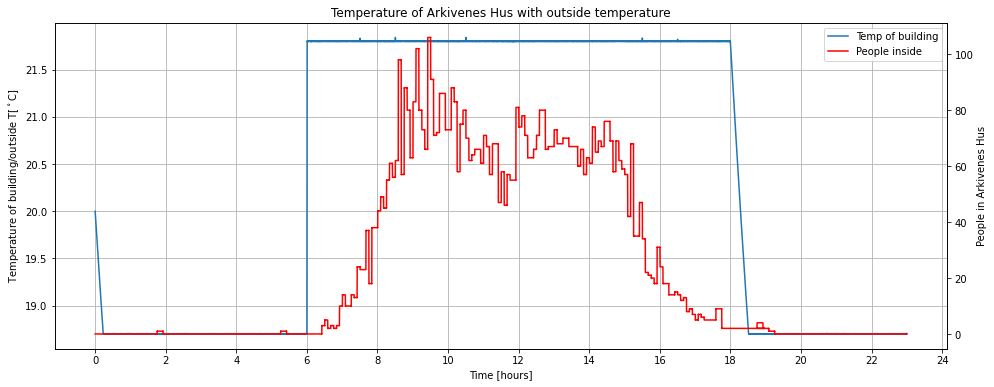

In [ ]:
fig = plt.figure(figsize=(16, 6))
ax1 = fig.add_subplot(111)
pd.plotting.register_matplotlib_converters()
plt.grid()
plt.title("Temperature of Arkivenes Hus with outside temperature")

# NORCE temperature plot

ax1.set_xlabel('Time [hours]')
ax1.set_ylabel('Temperature of building/outside T[$^\circ$C]')
ax1.set_xticks(np.arange((min(tSimArray)/dt),(max(tSimArray)/dt)+2,2))
legend1 = ax1.plot(tSimArray/dt, solVaryingOutsideTemp-K, label="Temp of building")

# Displaying people 
ax2 = ax1.twinx()
peopleList = case2ModelVaryingOutsideTemp.QpeopleList

timepeopleList = np.array([row[0] for row in peopleList])
ValuepeopleList = np.array([row[1] for row in peopleList])

legend2 = ax2.plot(timepeopleList/3600, ValuepeopleList/80, color='red', label="People inside")
ax2.set_ylabel('People in Arkivenes Hus')

lns = legend1+legend2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0)
plt.show()

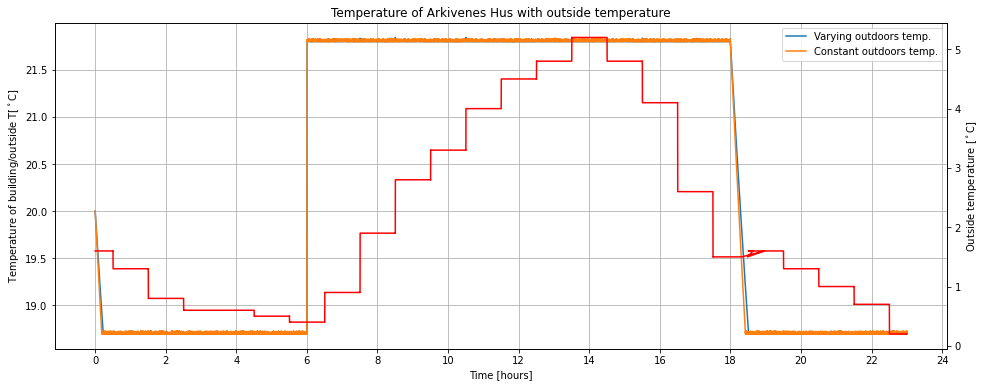

In [ ]:
# Constant vs Varying with outside temp plot
fig = plt.figure(figsize=(16, 6))
ax1 = fig.add_subplot(111)
plt.grid()
plt.title("Temperature of Arkivenes Hus with outside temperature")

ax1.set_xlabel('Time [hours]')
ax1.set_ylabel('Temperature of building/outside T[$^\circ$C]')
ax1.set_xticks(np.arange((min(tSimArray)/dt),(max(tSimArray)/dt)+2,2))
ax1.plot(tSimArray/dt, solVaryingOutsideTemp-K, label="Varying outdoors temp.")
ax1.plot(tSimArray/dt, solConstantTemp-K, label="Constant outdoors temp.")

ax2 = ax1.twinx()

OutsidetempList = case2ModelVaryingOutsideTemp.ToutLst

timeOutsidetempList = np.array([row[0] for row in OutsidetempList])
ValueOutsidetempList = np.array([row[1] for row in OutsidetempList])

ax2.plot(timeOutsidetempList/3600, ValueOutsidetempList-K, color='red')
ax2.set_ylabel('Outside temperature [$^\circ$C]')


ax1.legend()
plt.show()

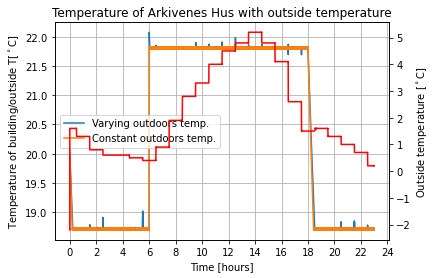

In [ ]:
fig, ax1 = plt.subplots()
plt.grid()
plt.title("Temperature of Arkivenes Hus with outside temperature")

ax1.set_xlabel('Time [hours]')
ax1.set_ylabel('Temperature of building/outside T[$^\circ$C]')
ax1.set_xticks(np.arange((min(tSimArray)/dt),(max(tSimArray)/dt)+2,2))
ax1.plot(tSimArray/dt, solVaryingOutsideTemp-K, label="Varying outdoors temp.")
ax1.plot(tSimArray/dt, solConstantTemp-K, label="Constant outdoors temp.")

ax2 = ax1.twinx()

OutsidetempList = case2ModelVaryingOutsideTemp.ToutLst

timeOutsidetempList = np.array([row[0] for row in OutsidetempList])
ValueOutsidetempList = np.array([row[1] for row in OutsidetempList])

ax2.plot(timeOutsidetempList/3600, ValueOutsidetempList-K, color='red')
ax2.set_ylabel('Outside temperature [$^\circ$C]')


ax1.legend()
plt.show()

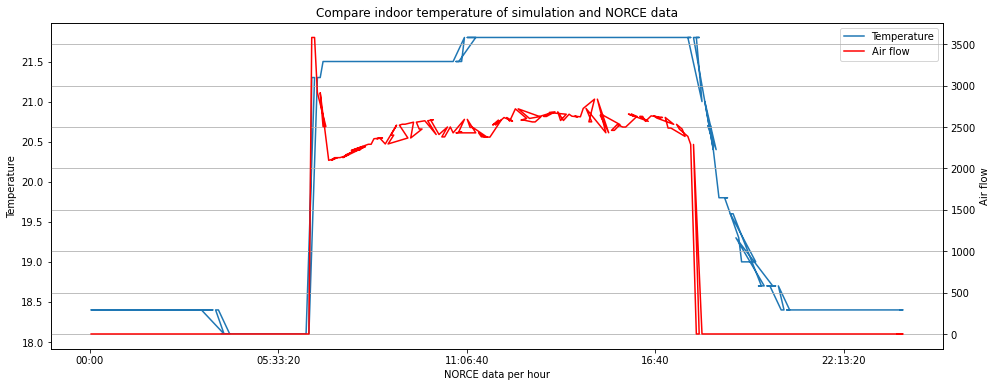

In [9]:

import pandas as pd
import datetime

fig = plt.figure(figsize=(16, 6))
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()
plt.title("Compare indoor temperature of simulation and NORCE data")
plt.grid()

dfTemp, idxTemp = convertTime('/content/drive/MyDrive/UiS/1 Master Thesis/data/extract_temp_2.csv')
dfFlow, idxFlow = convertTime('/content/drive/MyDrive/UiS/1 Master Thesis/data/extract_flow_2.csv')

pd.plotting.register_matplotlib_converters()

# NORCE temperature plot
legend1=ax1.plot(dfTemp.time, dfTemp.value, label="Temperature")
ax1.set_xticks(idxTemp)
ax1.set_xlabel("NORCE data per hour")
ax1.set_ylabel("Temperature")

# NORCE Flow plot
legend2=ax2.plot(dfFlow.time, dfFlow.value, label="Air flow", color='red')
ax2.set_ylabel("Air flow")

lns = legend1+legend2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0)

## Comparing NORCE and simulation data

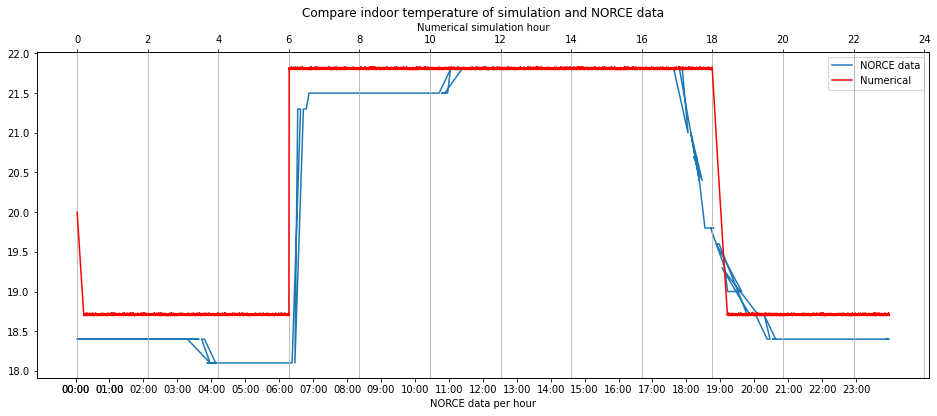

In [ ]:
import pandas as pd
import datetime

fig = plt.figure(figsize=(16, 6))
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()
plt.title("Compare indoor temperature of simulation and NORCE data")
plt.grid()

dfTemp, idxTemp = convertTime('/content/drive/MyDrive/UiS/1 Master Thesis/data/extract_temp_2.csv')

pd.plotting.register_matplotlib_converters()

# NORCE data plot
legend1=ax1.plot(dfTemp.time, dfTemp.value, label="NORCE data")
ax1.set_xticks(idxTemp)
ax1.set_xlabel("NORCE data per hour")

# Numerical plot
ax2.set_xticks(np.arange(0,24+1,2))
legend2=ax2.plot(tSimArray/3600, solConstantTemp-K, label="Numerical", color='red')
ax2.set_xlabel("Numerical simulation hour")
ax2.set_ylabel("Temperature indoors [$^\circ$C]")

lns = legend1+legend2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0)


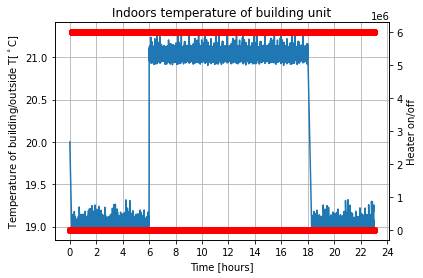

In [ ]:

testLst = [0]
coordLst = []
for i,val in enumerate(ValueHeater):
  if val != testLst[-1]:
    testLst.append(val)
    coordLst.append(i)


heaterTemp = np.array(case2Model.heaterOnOffLst)

timeHeater = [row[0] for row in heaterTemp]
ValueHeater = [row[1] for row in heaterTemp]

fig, ax1 = plt.subplots()
plt.grid()
plt.title("Indoors temperature of building unit")

ax1.set_xlabel('Time [hours]')
ax1.set_ylabel('Temperature of building/outside T[$^\circ$C]')
ax1.set_xticks(np.arange((min(tSimArray)/dt),(max(tSimArray)/dt)+2,2))
ax1.plot(tSimArray/dt, solConstantTemp-K, label="Numerical")

ax2 = ax1.twinx()

coordLst = np.hstack(coordLst)

ax2.scatter(np.array(timeHeater)/dt, np.array(ValueHeater), color='red')
ax2.set_ylabel('Heater on/off')

plt.show()

# People vs Temperature

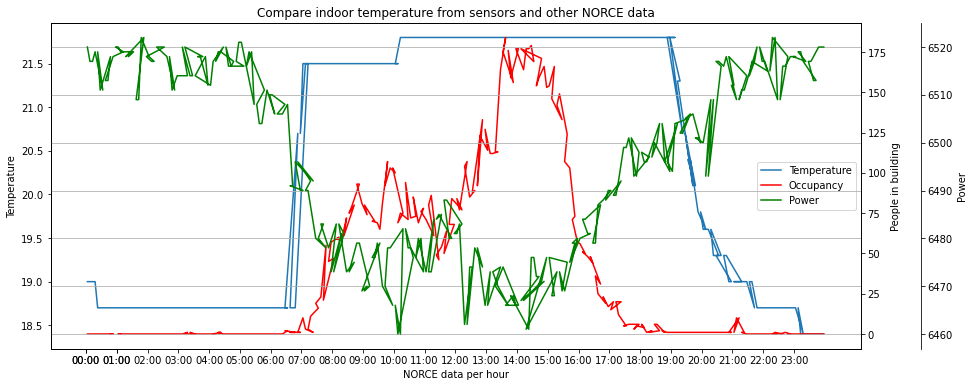

In [ ]:
import pandas as pd
import datetime

fig = plt.figure(figsize=(18, 6))
fig.subplots_adjust(right=0.75)
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()
ax3 = ax1.twinx()
plt.title("Compare indoor temperature from sensors and other NORCE data")
plt.grid()

dfTemp, idxTemp = convertTime('/content/drive/MyDrive/UiS/1 Master Thesis/data/extract_temp_2.csv')
dfPeople1, idxPeople1 = convertTime('/content/drive/MyDrive/UiS/1 Master Thesis/data/people1.csv')
dfPeople2, idxPeople2 = convertTime('/content/drive/MyDrive/UiS/1 Master Thesis/data/people2.csv')
dfPower1, idxPower1 = convertTime('/content/drive/MyDrive/UiS/1 Master Thesis/data/power1.csv')
dfPower2, idxPower2 = convertTime('/content/drive/MyDrive/UiS/1 Master Thesis/data/power2.csv')

dfPeople = dfPeople1.copy()
dfPeople.value = dfPeople.value + dfPeople2.value

dfPower = dfPower1.copy()
dfPower.value = dfPower.value + dfPower2.value

pd.plotting.register_matplotlib_converters()

# NORCE temperature plot
legend1=ax1.plot(dfTemp.time, dfTemp.value, label="Temperature")

ax1.set_xlabel("NORCE data per hour")
ax1.set_ylabel("Temperature")

# NORCE People plot
legend2=ax2.plot(dfPeople.time, dfPeople.value, label="Occupancy", color='red')
ax2.set_ylabel("People in building")


legend3=ax3.plot(dfPower2.time, dfPower2.value, label="Power", color='green')
ax3.set_ylabel("Power")
ax3.spines['right'].set_position(('outward', 60))

lns = legend1+legend2+legend3
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=7)
ax1.set_xticks(idxTemp)
plt.show()

In [ ]:
sum(dfPower2.value)/len(dfPower2.value)

6496.340277777777

85.0
55.0
30.0


# Power vs Outdoortemp

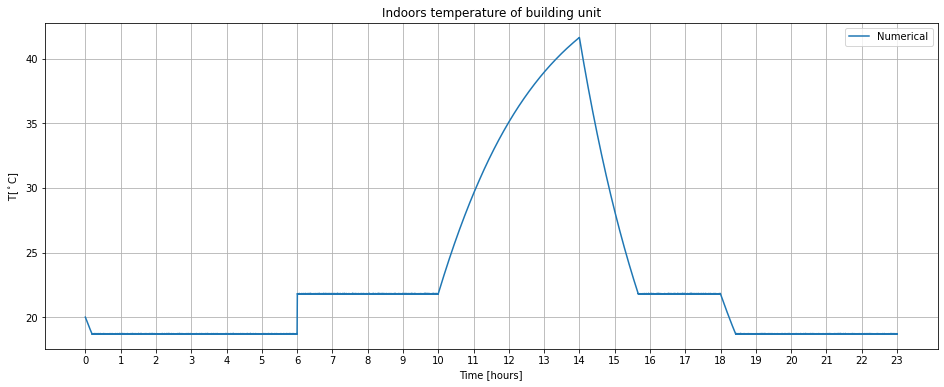

In [75]:
from scipy.integrate import odeint
import time
from datetime import datetime, timedelta
#dfOutdoorTemp, idxOutdoorTemp = convertTime('/content/drive/MyDrive/UiS/1 Master Thesis/data/correlated_weather_data.csv')
dfOutdoorTemp2 = dfOutdoorTemp.copy()

dfPeople3 = dfPeople1.copy()
dfPeople3.value = dfPeople1.value + dfPeople2.value
dfPeople3 = dfPeople3.fillna(0)

dfPower3 = dfPower2.copy()

K = 273.15
dt = 60*60
simTime = 23*dt
tolerance = 1e-4

dfOutdoorTemp2['time'] = dfOutdoorTemp2['time'].apply(lambda x: x.hour*3600 + x.minute * 60 + x.second)
dfOutdoorTemp2['value'] = dfOutdoorTemp2['value'].apply(lambda y: y + K)

dfPeople3['time'] = dfPeople3['time'].apply(lambda x: x.hour*3600 + x.minute * 60 + x.second)

dfPower3['time'] = dfPower3['time'].apply(lambda x: x.hour*3600 + x.minute * 60 + x.second)



tSimArray=np.arange(0,simTime,1)

y0 = 20+K
Toutside = -2.2 + K #-2.2 +K
case2ModelPowerVsOutdoor = model(Toutside,dt = dt,simTime=simTime, OutsideDataArray=dfOutdoorTemp2, peopleDataArray=dfPeople3, QheaterDataArray=dfPower3 )
solPowerVsOutdoor = odeint(case2ModelPowerVsOutdoor.buildingModel, y0, tSimArray,args=(False,False,False ),  rtol=tolerance,atol=tolerance) 

fig = plt.figure(figsize=(16, 6))
plt.grid()
plt.xticks(np.arange(0,24,1))

plt.plot(tSimArray/dt, solPowerVsOutdoor-K, label="Numerical")
plt.xlabel('Time [hours]')
plt.ylabel('T[$^\circ$C]')
plt.title("Indoors temperature of building unit")
plt.legend()

# plt.show()

In [70]:
case2ModelPowerVsOutdoor.vIn

0.44119444444444444

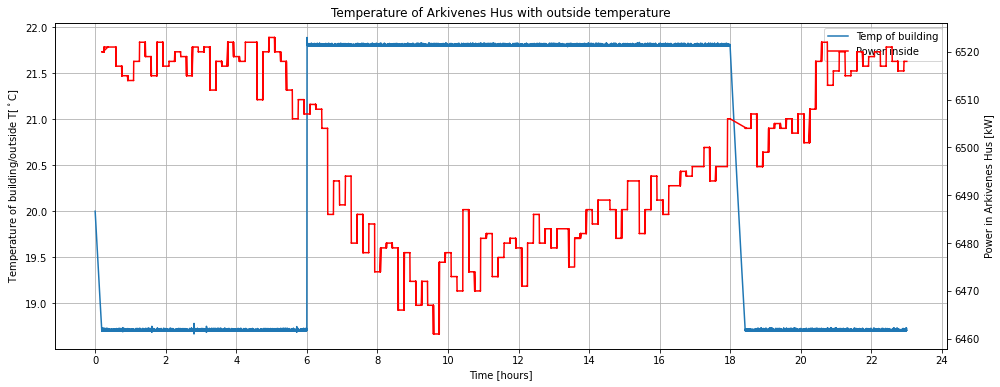

In [64]:
fig = plt.figure(figsize=(16, 6))
ax1 = fig.add_subplot(111)
pd.plotting.register_matplotlib_converters()
plt.grid()
plt.title("Temperature of Arkivenes Hus with outside temperature")

# NORCE temperature plot

ax1.set_xlabel('Time [hours]')
ax1.set_ylabel('Temperature of building/outside T[$^\circ$C]')
ax1.set_xticks(np.arange((min(tSimArray)/dt),(max(tSimArray)/dt)+2,2))
legend1 = ax1.plot(tSimArray/dt, solPowerVsOutdoor-K, label="Temp of building")

# Displaying Power 
ax2 = ax1.twinx()
PowerList = case2ModelPowerVsOutdoor.PowerList

timePowerList = np.array([row[0] for row in PowerList])
ValuePowerList = np.array([row[1] for row in PowerList])

ValuePowerList2 = ValuePowerList[np.where(ValuePowerList > 0)]
timePowerList2 = timePowerList[np.where(ValuePowerList > 0)]

legend2 = ax2.plot(timePowerList2/3600, ValuePowerList2/1000, color='red', label="Power inside")
ax2.set_ylabel('Power in Arkivenes Hus [kW]')

lns = legend1+legend2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0)
plt.show()

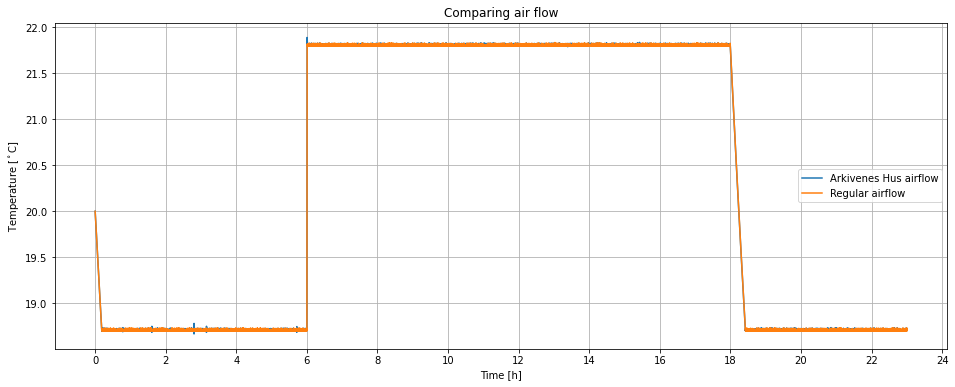

In [61]:
import pandas as pd
import datetime

fig = plt.figure(figsize=(16, 6))
ax1 = fig.add_subplot(111)

plt.title("Comparing air flow")
plt.grid()
pd.plotting.register_matplotlib_converters()

# Indoors temperature
legend1=ax1.plot(tSimArray/dt, solPowerVsOutdoor-K, label="Arkivenes Hus airflow")
legend2=ax1.plot(tSimArray/dt, solConstantTemp-K, label="Regular airflow")
ax1.set_xticks(np.arange((min(tSimArray)/dt),(max(tSimArray)/dt)+2,2))
ax1.set_xlabel("Time [h]")
ax1.set_ylabel('Temperature [$^\circ$C]')
# Power

PowerList = case2ModelPowerVsOutdoor.PowerList

ValuePowerList2 = ValuePowerList[np.where(ValuePowerList > 0)]
timePowerList2 = timePowerList[np.where(ValuePowerList > 0)]

# ax2 = ax1.twinx()
#legend3 = ax2.plot(timePowerList2/3600, ValuePowerList2/1000, color='red', label="Power inside")
#ax2.set_ylabel('Power in Arkivenes Hus')

lns = legend1+legend2#+legend3
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc="center right")

plt.show()

# All variables

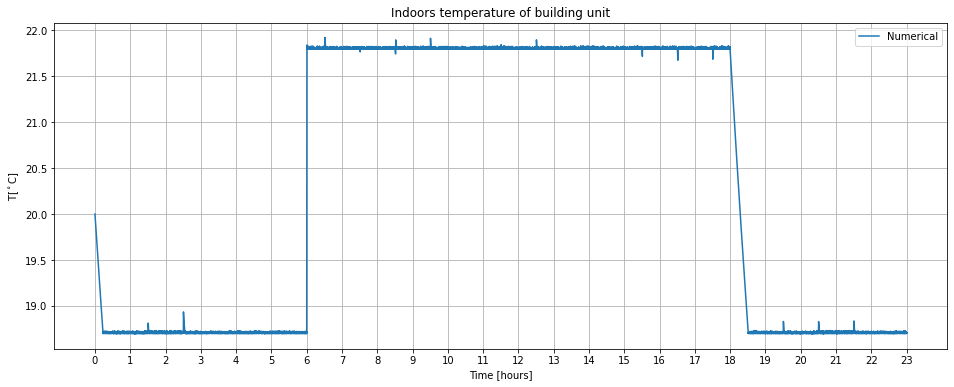

In [ ]:
from scipy.integrate import odeint
import time
from datetime import datetime, timedelta
#dfOutdoorTemp, idxOutdoorTemp = convertTime('/content/drive/MyDrive/UiS/1 Master Thesis/data/correlated_weather_data.csv')
dfOutdoorTemp2 = dfOutdoorTemp.copy()

dfPeople3 = dfPeople1.copy()
dfPeople3.value = dfPeople1.value + dfPeople2.value
dfPeople3 = dfPeople3.fillna(0)

dfPower3 = dfPower2.copy()


K = 273.15
dt = 60*60
simTime = 23*dt
tolerance = 1e-4

dfOutdoorTemp2['time'] = dfOutdoorTemp2['time'].apply(lambda x: x.hour*3600 + x.minute * 60 + x.second)
dfOutdoorTemp2['value'] = dfOutdoorTemp2['value'].apply(lambda y: y + K)

dfPeople3['time'] = dfPeople3['time'].apply(lambda x: x.hour*3600 + x.minute * 60 + x.second)

dfPower3['time'] = dfPower3['time'].apply(lambda x: x.hour*3600 + x.minute * 60 + x.second)



tSimArray=np.arange(0,simTime,1)

y0 = 20+K
Toutside = -2.2 + K #-2.2 +K
case2ModelPowerVsOutdoor = model(Toutside,dt = dt,simTime=simTime, OutsideDataArray=dfOutdoorTemp2, peopleDataArray=dfPeople3, QheaterDataArray=dfPower3 )
solPowerVsOutdoor = odeint(case2ModelPowerVsOutdoor.buildingModel, y0, tSimArray,args=(True,True,True ),  rtol=tolerance,atol=tolerance) 

fig = plt.figure(figsize=(16, 6))
plt.grid()
plt.xticks(np.arange(0,24,1))

plt.plot(tSimArray/dt, solPowerVsOutdoor-K, label="Numerical")
plt.xlabel('Time [hours]')
plt.ylabel('T[$^\circ$C]')
plt.title("Indoors temperature of building unit")
plt.legend()

# plt.show()

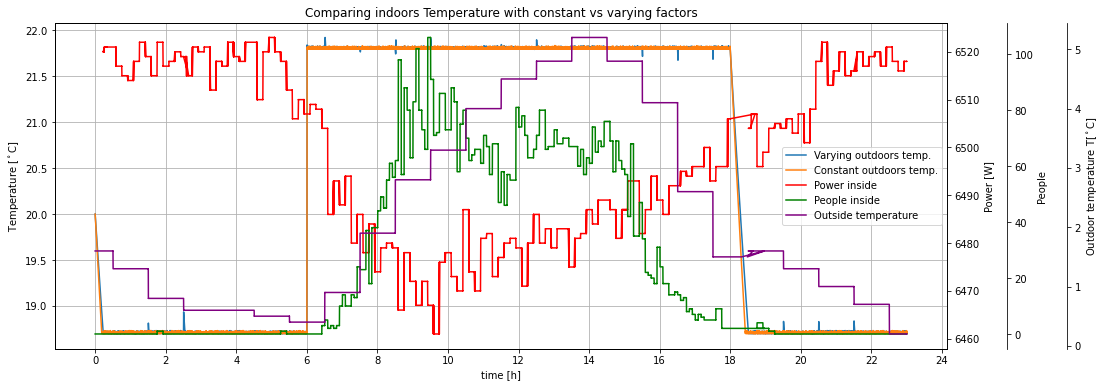

In [ ]:
import pandas as pd
import datetime

fig = plt.figure(figsize=(16, 6))
ax1 = fig.add_subplot(111)

plt.title("Comparing indoors Temperature with constant vs varying factors")
plt.grid()
pd.plotting.register_matplotlib_converters()

# Indoors temperature
legend1=ax1.plot(tSimArray/dt, solPowerVsOutdoor-K, label="Varying outdoors temp.")
legend2=ax1.plot(tSimArray/dt, solConstantTemp-K, label="Constant outdoors temp.")
ax1.set_xticks(np.arange((min(tSimArray)/dt),(max(tSimArray)/dt)+2,2))
ax1.set_xlabel("time [h]")
ax1.set_ylabel('Temperature [$^\circ$C]')
# Power ToutLst QpeopleList

# Power
ax2 = ax1.twinx()
PowerList = case2ModelPowerVsOutdoor.PowerList

timePowerList = np.array([row[0] for row in PowerList])
ValuePowerList = np.array([row[1] for row in PowerList])

ValuePowerList2 = ValuePowerList[np.where(ValuePowerList > 0)]
timePowerList2 = timePowerList[np.where(ValuePowerList > 0)]
legend3 = ax2.plot(timePowerList2/3600, ValuePowerList2/1000, label="Power inside", color="red")
# People
ax3 = ax1.twinx()

ax3.set_ylabel("People")
peopleList = case2ModelVaryingOutsideTemp.QpeopleList

timepeopleList = np.array([row[0] for row in peopleList])
ValuepeopleList = np.array([row[1] for row in peopleList])

legend4 = ax3.plot(timepeopleList/3600, ValuepeopleList/80, label="People inside", color="green")
ax3.spines['right'].set_position(('outward', 60))
# Outside temperature
ax4 = ax1.twinx()
ax4.set_ylabel("Outdoor temperature T[$^\circ$C]")
OutsidetempList = case2ModelVaryingOutsideTemp.ToutLst

timeOutsidetempList = np.array([row[0] for row in OutsidetempList])
ValueOutsidetempList = np.array([row[1] for row in OutsidetempList])

legend5 = ax4.plot(timeOutsidetempList/3600, ValueOutsidetempList-K, label="Outside temperature", color="purple")
ax4.spines['right'].set_position(('outward', 120))




ax2.set_ylabel('Power [W]')

lns = legend1+legend2+legend3+legend4+legend5
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc="center right")

plt.show()

# Airflow


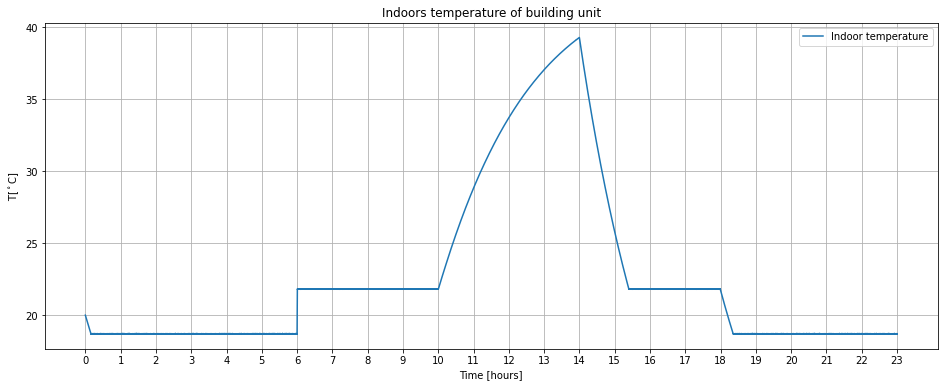

In [101]:
from scipy.integrate import odeint
import time
from datetime import datetime, timedelta
#dfOutdoorTemp, idxOutdoorTemp = convertTime('/content/drive/MyDrive/UiS/1 Master Thesis/data/correlated_weather_data.csv')
dfOutdoorTemp2 = dfOutdoorTemp.copy()

dfPeople3 = dfPeople1.copy()
dfPeople3.value = dfPeople1.value + dfPeople2.value
dfPeople3 = dfPeople3.fillna(0)

dfPower3 = dfPower2.copy()

K = 273.15
dt = 60*60
simTime = 23*dt
tolerance = 1e-4

dfOutdoorTemp2['time'] = dfOutdoorTemp2['time'].apply(lambda x: x.hour*3600 + x.minute * 60 + x.second)
dfOutdoorTemp2['value'] = dfOutdoorTemp2['value'].apply(lambda y: y + K)

dfPeople3['time'] = dfPeople3['time'].apply(lambda x: x.hour*3600 + x.minute * 60 + x.second)

dfPower3['time'] = dfPower3['time'].apply(lambda x: x.hour*3600 + x.minute * 60 + x.second)



tSimArray=np.arange(0,simTime,1)

y0 = 20+K
Toutside = -2.2 + K #-2.2 +K
airFlow1Model = model(Toutside,dt = dt,simTime=simTime, OutsideDataArray=dfOutdoorTemp2, peopleDataArray=dfPeople3, QheaterDataArray=dfPower3 )
solAirFlow1 = odeint(airFlow1Model.buildingModel, y0, tSimArray,args=(False,False,False ),  rtol=tolerance,atol=tolerance) 

fig = plt.figure(figsize=(16, 6))
plt.grid()
plt.xticks(np.arange(0,24,1))

plt.plot(tSimArray/dt, solAirFlow1-K, label="Indoor temperature")
plt.xlabel('Time [hours]')
plt.ylabel('T[$^\circ$C]')
plt.title("Indoors temperature of building unit")
plt.legend()

# plt.show()

# Airflow 2

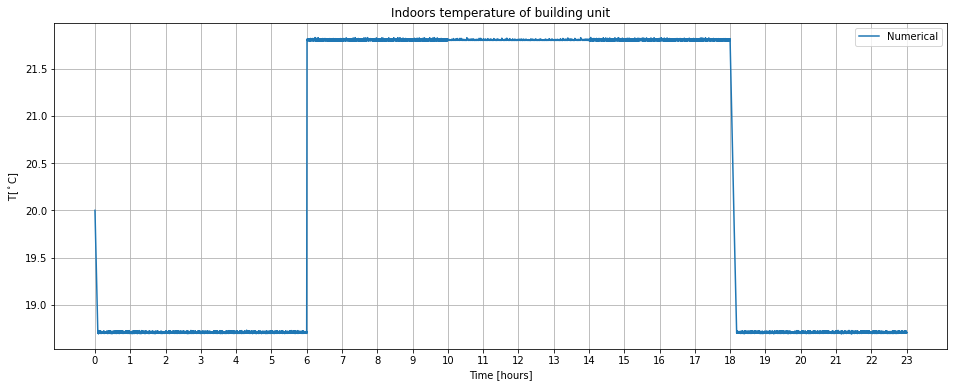

In [97]:
from scipy.integrate import odeint
import time
from datetime import datetime, timedelta
#dfOutdoorTemp, idxOutdoorTemp = convertTime('/content/drive/MyDrive/UiS/1 Master Thesis/data/correlated_weather_data.csv')
dfOutdoorTemp2 = dfOutdoorTemp.copy()

dfPeople3 = dfPeople1.copy()
dfPeople3.value = dfPeople1.value + dfPeople2.value
dfPeople3 = dfPeople3.fillna(0)

dfPower3 = dfPower2.copy()

K = 273.15
dt = 60*60
simTime = 23*dt
tolerance = 1e-4

dfOutdoorTemp2['time'] = dfOutdoorTemp2['time'].apply(lambda x: x.hour*3600 + x.minute * 60 + x.second)
dfOutdoorTemp2['value'] = dfOutdoorTemp2['value'].apply(lambda y: y + K)

dfPeople3['time'] = dfPeople3['time'].apply(lambda x: x.hour*3600 + x.minute * 60 + x.second)

dfPower3['time'] = dfPower3['time'].apply(lambda x: x.hour*3600 + x.minute * 60 + x.second)

tSimArray=np.arange(0,simTime,1)

y0 = 20+K
Toutside = -2.2 + K #-2.2 +K
airFlow1Model2 = model(Toutside,dt = dt,simTime=simTime, OutsideDataArray=dfOutdoorTemp2, peopleDataArray=dfPeople3, QheaterDataArray=dfPower3 )
solAirFlow2 = odeint(airFlow1Model2.buildingModel, y0, tSimArray,args=(False,False,False ),  rtol=tolerance,atol=tolerance) 

fig = plt.figure(figsize=(16, 6))
plt.grid()
plt.xticks(np.arange(0,24,1))

plt.plot(tSimArray/dt, solAirFlow2-K, label="Numerical")
plt.xlabel('Time [hours]')
plt.ylabel('T[$^\circ$C]')
plt.title("Indoors temperature of building unit")
plt.legend()

# plt.show()

# Airflow 3

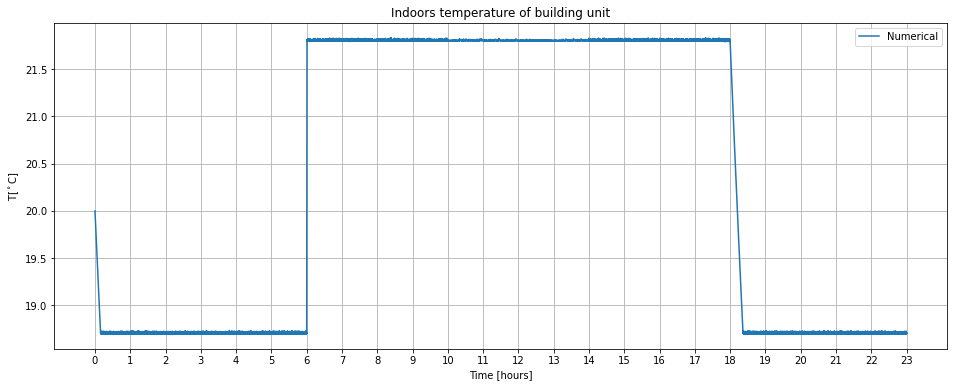

In [94]:
from scipy.integrate import odeint
import time
from datetime import datetime, timedelta
#dfOutdoorTemp, idxOutdoorTemp = convertTime('/content/drive/MyDrive/UiS/1 Master Thesis/data/correlated_weather_data.csv')
dfOutdoorTemp2 = dfOutdoorTemp.copy()

dfPeople3 = dfPeople1.copy()
dfPeople3.value = dfPeople1.value + dfPeople2.value
dfPeople3 = dfPeople3.fillna(0)

dfPower3 = dfPower2.copy()

K = 273.15
dt = 60*60
simTime = 23*dt
tolerance = 1e-4

dfOutdoorTemp2['time'] = dfOutdoorTemp2['time'].apply(lambda x: x.hour*3600 + x.minute * 60 + x.second)
dfOutdoorTemp2['value'] = dfOutdoorTemp2['value'].apply(lambda y: y + K)

dfPeople3['time'] = dfPeople3['time'].apply(lambda x: x.hour*3600 + x.minute * 60 + x.second)

dfPower3['time'] = dfPower3['time'].apply(lambda x: x.hour*3600 + x.minute * 60 + x.second)

tSimArray=np.arange(0,simTime,1)

y0 = 20+K
Toutside = -2.2 + K #-2.2 +K
airFlow1Model3 = model(Toutside,dt = dt,simTime=simTime, OutsideDataArray=dfOutdoorTemp2, peopleDataArray=dfPeople3, QheaterDataArray=dfPower3 )
solAirFlow3 = odeint(airFlow1Model3.buildingModel, y0, tSimArray,args=(False,False,False ),  rtol=tolerance,atol=tolerance) 

fig = plt.figure(figsize=(16, 6))
plt.grid()
plt.xticks(np.arange(0,24,1))

plt.plot(tSimArray/dt, solAirFlow3-K, label="Numerical")
plt.xlabel('Time [hours]')
plt.ylabel('T[$^\circ$C]')
plt.title("Indoors temperature of building unit")
plt.legend()

# plt.show()

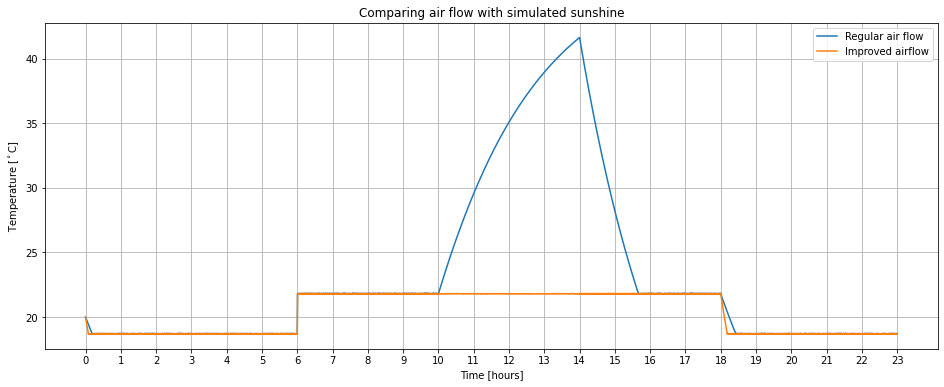

In [98]:
fig = plt.figure(figsize=(16, 6))
plt.grid()
plt.xticks(np.arange(0,24,1))

plt.plot(tSimArray/dt, solAirFlow1-K, label="Regular air flow")
plt.plot(tSimArray/dt, solAirFlow2-K, label="Improved airflow")
#plt.plot(tSimArray/dt, solAirFlow3-K, label="Improved airflow, only when sun is up")
plt.xlabel('Time [hours]')
plt.ylabel('Temperature [$^\circ$C]')
plt.title("Comparing air flow with simulated sunshine")
plt.legend()
plt.show()

# Compare other days

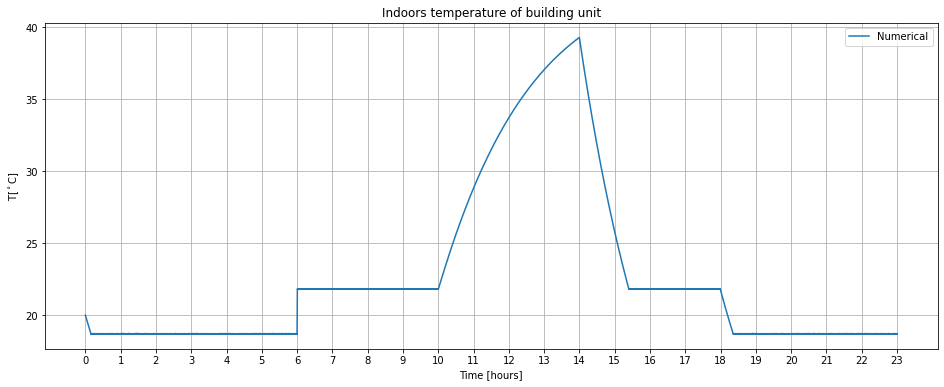

In [16]:
from scipy.integrate import odeint
import numpy as np
K = 273.15
dt = 60*60
simTime = 23*dt
tolerance = 1e-4

tSimArray=np.arange(0,simTime,1)
y0 = 20+K
Toutside = -2.2 + K #-2.2 +K
case2Model = model(Toutside,dt = dt,simTime=simTime )
solConstantTemp = odeint(case2Model.buildingModel, y0, tSimArray,args=(False, ),  rtol=tolerance,atol=tolerance) 

# fig = plt.figure(figsize=(16, 6))
# plt.grid()
# plt.xticks(np.arange(0,24,1))

# plt.plot(tSimArray/dt, solConstantTemp-K, label="Numerical")
# plt.xlabel('Time [hours]')
# plt.ylabel('T[$^\circ$C]')
# plt.title("Indoors temperature of building unit")
# plt.legend()

# plt.show()

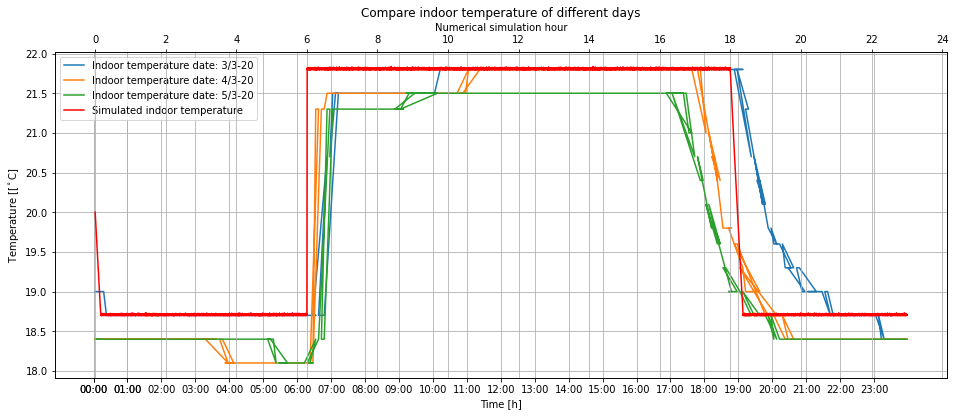

In [21]:
import pandas as pd
import datetime

fig = plt.figure(figsize=(16, 6))
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()
plt.title("Compare indoor temperature of different days")
plt.grid()

dfTemp1, idxTemp1 = convertTime('/content/drive/MyDrive/UiS/1 Master Thesis/data/extract_temp_2.csv')
dfTemp2, idxTemp2 = convertTime('/content/drive/MyDrive/UiS/1 Master Thesis/data/extract_temp_2.csv',4)
dfTemp3, idxTemp3 = convertTime('/content/drive/MyDrive/UiS/1 Master Thesis/data/extract_temp_2.csv',5)

pd.plotting.register_matplotlib_converters()

# NORCE data plot
legend1=ax1.plot(dfTemp1.time, dfTemp1.value, label="Indoor temperature date: 3/3-20")
legend2=ax1.plot(dfTemp2.time, dfTemp2.value, label="Indoor temperature date: 4/3-20")
legend3=ax1.plot(dfTemp3.time, dfTemp3.value, label="Indoor temperature date: 5/3-20")
ax1.set_xticks(idxTemp1)
ax1.set_xlabel("Time [h]")
ax1.set_ylabel("Temperature [[$^\circ$C]")

# Numerical plot
ax2.set_xticks(np.arange(0,24+1,2))
legend4=ax2.plot(tSimArray/3600, solConstantTemp-K, label="Simulated indoor temperature", color='red')
ax2.set_xlabel("Simulated hour [h]")
ax2.set_ylabel("Simulated Temperature [$^\circ$C]")

lns = legend1+legend2+legend3+legend4
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0)
ax1.grid()

In [ ]:
from scipy.integrate import odeint
import numpy as np

#dfOutdoorTemp, idxOutdoorTemp = convertTime('/content/drive/MyDrive/UiS/1 Master Thesis/data/correlated_weather_data.csv')
dfFlow, idxFlow = convertTime('/content/drive/MyDrive/UiS/1 Master Thesis/data/extract_flow_2.csv')
dfPower2, idxPower2 = convertTime('/content/drive/MyDrive/UiS/1 Master Thesis/data/power2.csv')

dfPower3 = dfPower2.copy()
dfFlow2 = dfFlow.copy()


dfFlow2['time'] = dfFlow2['time'].apply(lambda x: x.hour*3600 + x.minute * 60 + x.second)
dfPower3['time'] = dfPower3['time'].apply(lambda x: x.hour*3600 + x.minute * 60 + x.second)

K = 273.15
dt = 60*60
simTime = 23*dt
tolerance = 1e-5

tSimArray=np.arange(0,simTime,1)
y0 = 20+K
Toutside = -2.2 + K #-2.2 +K
case2ModelPowerVFlow = model(Toutside,dt = dt,simTime=simTime, QheaterDataArray=dfPower3,QflowDataArray=dfFlow2 )
solPowerVFlow = odeint(case2ModelPowerVFlow.buildingModel, y0, tSimArray,args=(False,False,True,False ),  rtol=tolerance,atol=tolerance) 

fig = plt.figure(figsize=(16, 6))
plt.grid()
plt.xticks(np.arange(0,24,1))

plt.plot(tSimArray/dt, solPowerVFlow-K, label="Numerical")
plt.xlabel('Time [hours]')
plt.ylabel('T[$^\circ$C]')
plt.title("Indoors temperature of building unit")
plt.legend()

plt.show()

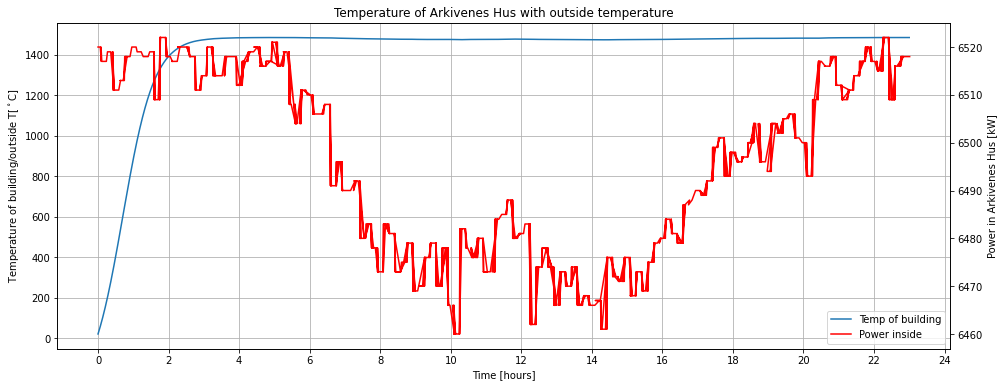

In [73]:
fig = plt.figure(figsize=(16, 6))
ax1 = fig.add_subplot(111)
pd.plotting.register_matplotlib_converters()
plt.grid()
plt.title("Temperature of Arkivenes Hus with outside temperature")

# NORCE temperature plot

ax1.set_xlabel('Time [hours]')
ax1.set_ylabel('Temperature of building/outside T[$^\circ$C]')
ax1.set_xticks(np.arange((min(tSimArray)/dt),(max(tSimArray)/dt)+2,2))
legend1 = ax1.plot(tSimArray/dt, solPowerVFlow-K, label="Temp of building")

# Displaying Power 
ax2 = ax1.twinx()
PowerList = case2ModelPowerVFlow.PowerList

timePowerList = np.array([row[0] for row in PowerList])
ValuePowerList = np.array([row[1] for row in PowerList])

ValuePowerList2 = ValuePowerList[np.where(ValuePowerList > 0)]
timePowerList2 = timePowerList[np.where(ValuePowerList > 0)]

legend2 = ax2.plot(timePowerList2/3600, ValuePowerList2/1000, color='red', label="Power inside")
ax2.set_ylabel('Power in Arkivenes Hus [kW]')

lns = legend1+legend2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0)
plt.show()

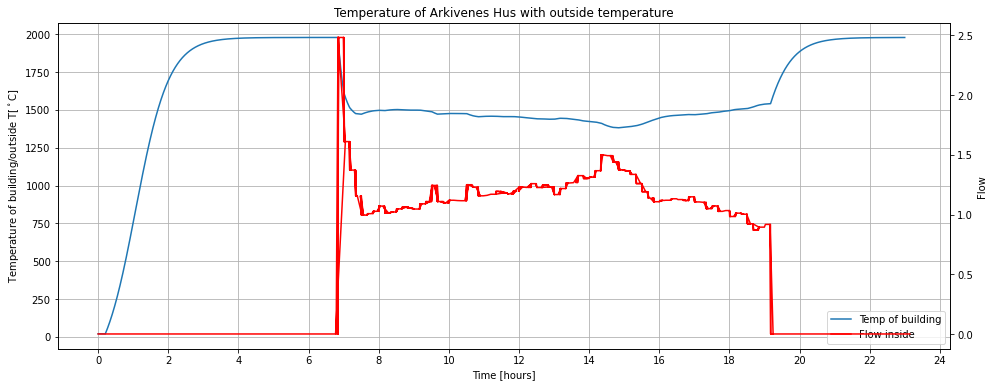

In [62]:
fig = plt.figure(figsize=(16, 6))
ax1 = fig.add_subplot(111)
pd.plotting.register_matplotlib_converters()
plt.grid()
plt.title("Temperature of Arkivenes Hus with outside temperature")

# NORCE temperature plot

ax1.set_xlabel('Time [hours]')
ax1.set_ylabel('Temperature of building/outside T[$^\circ$C]')
ax1.set_xticks(np.arange((min(tSimArray)/dt),(max(tSimArray)/dt)+2,2))
legend1 = ax1.plot(tSimArray/dt, solPowerVFlow-K, label="Temp of building")

# Displaying Power 
ax2 = ax1.twinx()
FlowList = case2ModelPowerVFlow.FlowList

timeFlowList = np.array([row[0] for row in FlowList])
ValueFlowList = np.array([row[1] for row in FlowList])

# ValueFlowList2 = ValueFlowList[np.where(ValueFlowList > 0)]
# timeFlowList2 = timeFlowList[np.where(ValueFlowList > 0)]

legend2 = ax2.plot(timeFlowList2/3600, ValueFlowList2, color='red', label="Flow inside")
ax2.set_ylabel('Flow')

lns = legend1+legend2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0)
plt.show()